In [1]:
import os
import gc
import yaml
import numpy as np
import pandas as pd
from PIL import Image
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import roc_auc_score
from scipy.ndimage.morphology import binary_erosion, binary_dilation
import time
import torch
from torch import nn
from torch import Tensor
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import timm
from io import StringIO
from time import time
from tqdm import tqdm

C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\gamer\AppData\Local\Temp\ipykernel_24592\1769195266.py:11: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation
C:\Users\gamer\AppData\Local\Temp\ipykernel_24592\1769195266.py:11: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, bin

In [14]:
DATA_DIR = "../data"  # "/kaggle/input/vesuvius-challenge-ink-detection"
TEST_DIR = "../data/test"  # "/kaggle/input/vesuvius-challenge-ink-detection/test"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "../model_checkpoints/best_efficientnet_b0-zdim_9-epoch_20-step_8000_final.pt"
# "/kaggle/input/vesuvius-model/efficientnet_b0-subvolume_30-zstart_27-zdim_10-round_8-step_4000-thr_0.6.pt"

## Functions

In [3]:
def load_png(fragment_id: str, png_name: str) -> np.ndarray:
    fragment_dir = os.path.join(TEST_DIR, fragment_id)
    path = os.path.join(fragment_dir, f"{png_name}.png")
    image = Image.open(path)
    return np.array(image)


def show_array(array: np.ndarray, name: str, ax, off=True):
    ax.imshow(array, cmap="gray")
    if off:
        ax.axis("off")
    ax.set_title(f"{name}, shape: {array.shape}")
    

def load_volume(fragment_id: str, z_start: int, z_dim: int) -> np.ndarray:
    volume_dir = os.path.join(TEST_DIR, fragment_id, "surface_volume")
    volume = []
    for i in range(z_start, z_start + z_dim):
        slice_path = os.path.join(volume_dir, f"{i:02d}.tif")
        slice_png = Image.open(slice_path)
        # normalize pixel intesity values into [0,1]
        slice_array = np.array(slice_png, dtype=np.float32) / 65535.0
        volume.append(slice_array)
    return np.stack(volume, axis=0)


def erode_mask(mask: np.ndarray, subvolume_size: int):
    eroded_mask = binary_erosion(mask, structure=np.ones((2*subvolume_size, 2*subvolume_size)))
    return eroded_mask


def pad_array(array: np.ndarray, subvolume_size: int) -> np.ndarray:
    padded_array = np.pad(array, pad_width=subvolume_size+1, mode="constant")
    return padded_array

In [4]:
config = {"model_name": "efficientnet_b0",
          "subvolume_size": 30,
          "z_start": 28,
          "z_dim": 9,
          "batch_size": 700,
          "epochs": 20,
          "train_steps": 8000,
          "threshold": 0.6,
          "seed": 1337}

In [5]:
frag_a = load_png(fragment_id="a", png_name="mask")
mask_a = erode_mask(frag_a, config["subvolume_size"])

# mask_b = load_png(fragment_id="b", png_name="mask")
# mask_b = erode_mask(mask_b, config["subvolume_size"])

## Dataset

In [7]:
class SubvolumeDatasetTest(Dataset):
    def __init__(self, volume: np.ndarray, pixels: List[Tuple], subvolume_size: int):
        self.volume = volume
        # pixels in test mask
        self.pixels = pixels
        self.subvolume_size = subvolume_size

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        y, x = self.pixels[idx]
        subvolume = self.volume[:,
                    y - self.subvolume_size : y + self.subvolume_size,
                    x - self.subvolume_size : x + self.subvolume_size]
        subvolume = torch.from_numpy(subvolume).to(torch.float32)
        return subvolume

In [8]:
def create_data_loader(batch_size: int, volume: np.ndarray, pixels: List[Tuple], subvolume_size: int):
    dataset = SubvolumeDatasetTest(volume, pixels, subvolume_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

## Model

In [9]:
# Define the model
class InkClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.backbone = timm.create_model(config["model_name"], pretrained=True, in_chans=config['z_dim'], num_classes=0)  # Set pretrained to true.
        self.backbone_dim = self.backbone(torch.rand(1, config["z_dim"], 2 * config["subvolume_size"], 2 * config["subvolume_size"])).shape[-1]
        self.classifier = nn.Linear(in_features=self.backbone_dim, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.backbone(x)  # Pretrained efficientnet_b0 model
        logits = self.classifier(x)  # Classifies as ink/no_ink
        out = self.sigmoid(logits)  # Sigmoid for some reason
        return out.flatten()

In [10]:
@torch.no_grad()
def infer_fn(test_loader: DataLoader, model: nn.Module, image_shape_2d: Tuple[int, int], pixels: List[Tuple[int, int]]) -> torch.tensor:
    model.eval()
    output = torch.zeros(image_shape_2d, dtype=torch.float32)
    for i, x in tqdm(enumerate(test_loader), total = len(test_loader), desc="Inference:"):
        x = x.to(DEVICE)
        batch_size = x.shape[0]

        yhat = model(x)
        for j, pred in enumerate(yhat):
            output[pixels[i * batch_size + j]] = pred
    return output

## RLE Options
Convert a binary image to run-length encoding format.

In [11]:
def rle(image):
    pixels = image.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def orig_rle(img):
    flat_img = img.flatten().astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

def fast_rle(img):
    flat_img = img.flatten().astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    predicted_arr = np.stack([starts_ix, lengths]).T.flatten()
    f = StringIO()
    np.savetxt(f, predicted_arr.reshape(1, -1), delimiter=" ", fmt="%d")
    return f.getvalue().strip()

def combined_rle(img):
    pixels = img.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    f = StringIO()
    np.savetxt(f, runs.reshape(1, -1), delimiter=" ", fmt="%d")
    return f.getvalue().strip()

In [12]:
def infer_for_fragment(fragment_id: str, config: dict, model: nn.Module) -> np.ndarray:
    mask = load_png(fragment_id, png_name="mask")
    mask = erode_mask(mask, config["subvolume_size"])
    image_shape_2d = mask.shape
    pixels = list(zip(*np.where(mask == 1)))
    del mask
    gc.collect()
    
    volume = load_volume(fragment_id, z_start=config["z_start"], z_dim=config["z_dim"])
    test_loader = create_data_loader(config["batch_size"], volume, pixels, config["subvolume_size"])
    ink_pred = infer_fn(test_loader, model, image_shape_2d, pixels)

    return ink_pred  # .gt(config["threshold"]).cpu().numpy().astype(int)

In [15]:
model = InkClassifier(config)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE)

InkClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(9, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

In [19]:
def save_predictions_image(ink_pred: Tensor, file_name: str) -> None:
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
    axs.flatten()

    axs[0][0].imshow(ink_pred.gt(0.45).cpu().numpy(), cmap="gray")
    axs[0][0].set_title("@ .45")

    # Show the output images at different thresholds
    axs[0][1].imshow(ink_pred.gt(0.4).cpu().numpy(), cmap="gray")
    axs[0][1].set_title("@ .4")

    axs[0][2].imshow(ink_pred.gt(0.5).cpu().numpy(), cmap="gray")
    axs[0][2].set_title("@ .5")

    axs[1][0].imshow(ink_pred.gt(0.6).cpu().numpy(), cmap="gray")
    axs[1][0].set_title("@ .6")

    axs[1][1].imshow(ink_pred.gt(0.7).cpu().numpy(), cmap="gray")
    axs[1][1].set_title("@ .7")

    axs[1][2].imshow(ink_pred.gt(0.8).cpu().numpy(), cmap="gray")
    axs[1][2].set_title("@ .8")

    [axi.set_axis_off() for axi in axs.ravel()]  # Turn off the axes on all the sub plots
    # plt.savefig(file_name, transparent=False)
    plt.show()
    print("Graph has saved")

In [20]:
@torch.no_grad()
def generate_ink_pred(val_loader: DataLoader, model: nn.Module, val_pixels, image_shape) -> Tensor:
    model.eval()  # Sets the model into evaluation mode
    output = torch.zeros(image_shape, dtype=torch.float32)
    for i, x in tqdm(enumerate(val_loader), total=len(val_loader), desc='Inference Batches'):
        x = x.to("cuda")
        batch_size = x.shape[0]

        yhat = model(x)
        for j, pred in enumerate(yhat):
            output[val_pixels[i * batch_size + j]] = pred
    return output

In [18]:
mask = load_png('a', png_name="mask")
mask = erode_mask(mask, config["subvolume_size"])
image_shape_2d = mask.shape
pixels = list(zip(*np.where(mask == 1)))

volume = load_volume('a', z_start=config["z_start"], z_dim=config["z_dim"])
test_loader = create_data_loader(config["batch_size"], volume, pixels, config["subvolume_size"])

In [21]:
# Jason custom inference. not from submission notebook
fragment_ids = os.listdir(TEST_DIR)
ink_preds_dict = {}
submission = []
start = time()
print(f"Inference for fragment A")
ink_pred = infer_fn(test_loader, model, image_shape_2d, pixels)
final = time()
total = final - start
print(f"Inference took {total:.4} seconds or {total/60:.4} minutes")

Inference::   0%|          | 0/31472 [00:00<?, ?it/s]

Inference for fragment A


Inference:: 100%|██████████| 31472/31472 [31:13<00:00, 16.80it/s]

Inference took 1.873e+03 seconds or 31.22 minutes


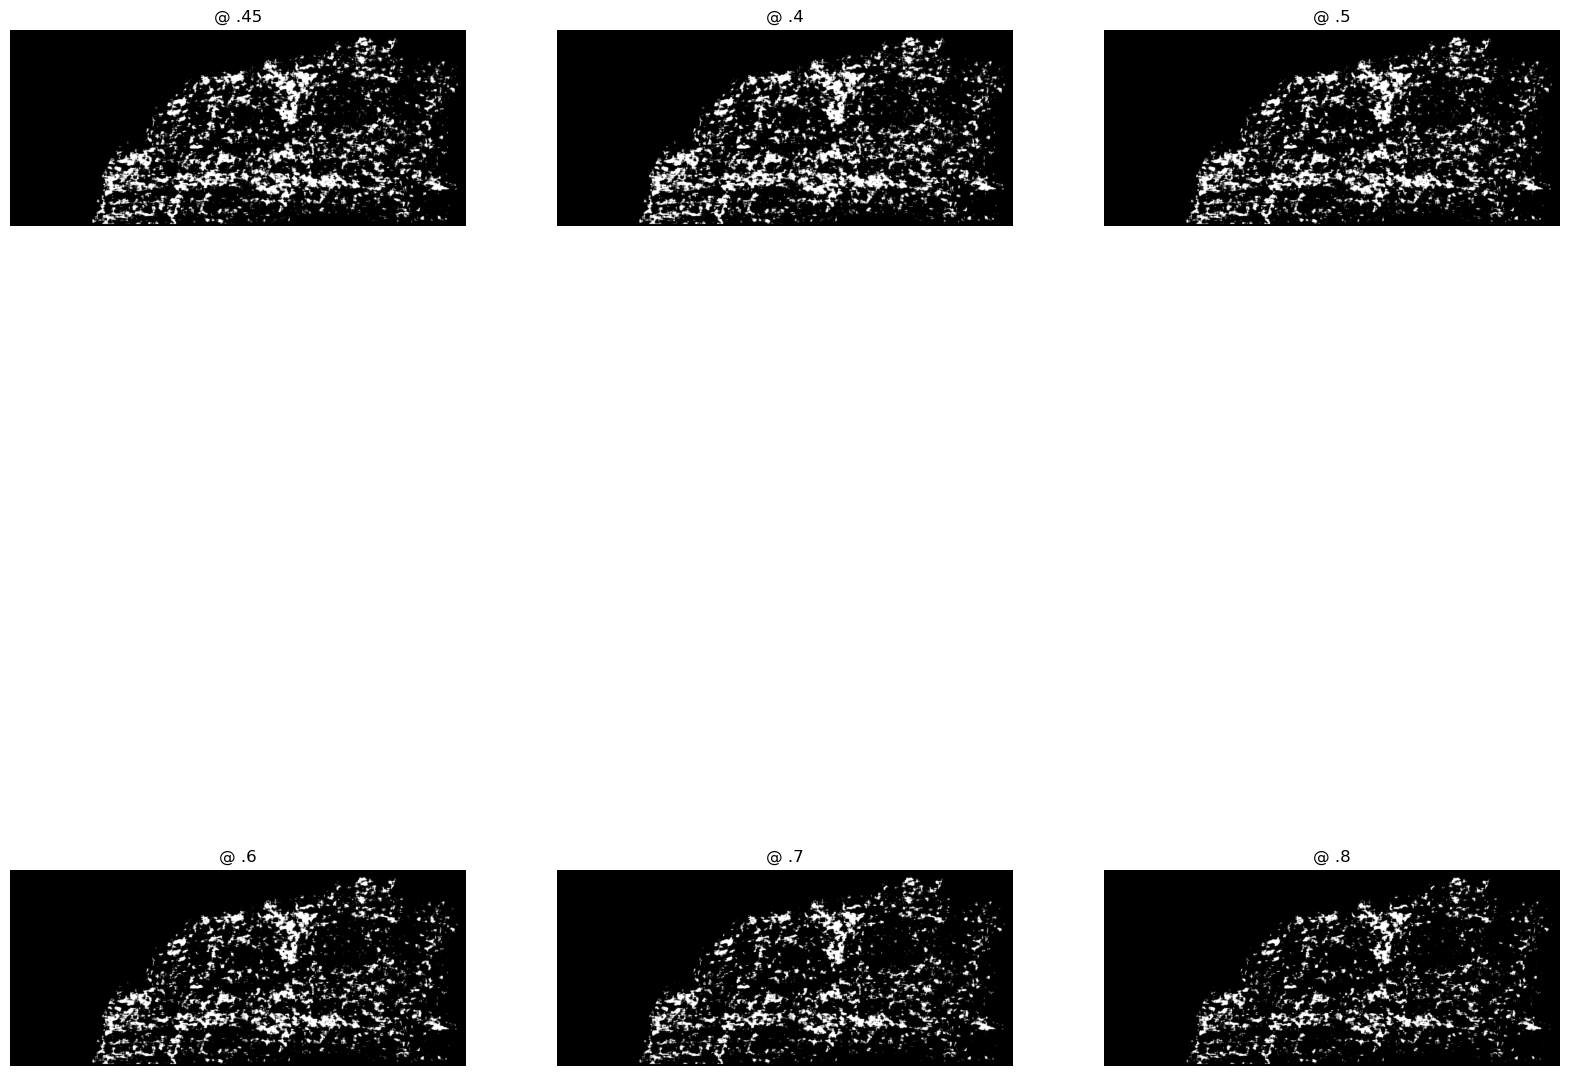

Graph has saved


In [22]:
save_predictions_image(ink_pred, None)

In [23]:
# Jason with trains method
print("Preds with train method instead.")
fragment_ids = os.listdir(TEST_DIR)
ink_preds_dict = {}
submission = []
start = time()
print(f"Inference for fragment A")
preds2 = generate_ink_pred(test_loader, model, pixels, mask.shape)
final = time()
total = final - start
print(f"Train inference took {total:.4} seconds or {total/60:.4} minutes")

Inference Batches:   0%|          | 0/31472 [00:00<?, ?it/s]

Preds with train method instead.
Inference for fragment A


Inference Batches: 100%|██████████| 31472/31472 [30:40<00:00, 17.10it/s]

Train inference took 1.841e+03 seconds or 30.68 minutes


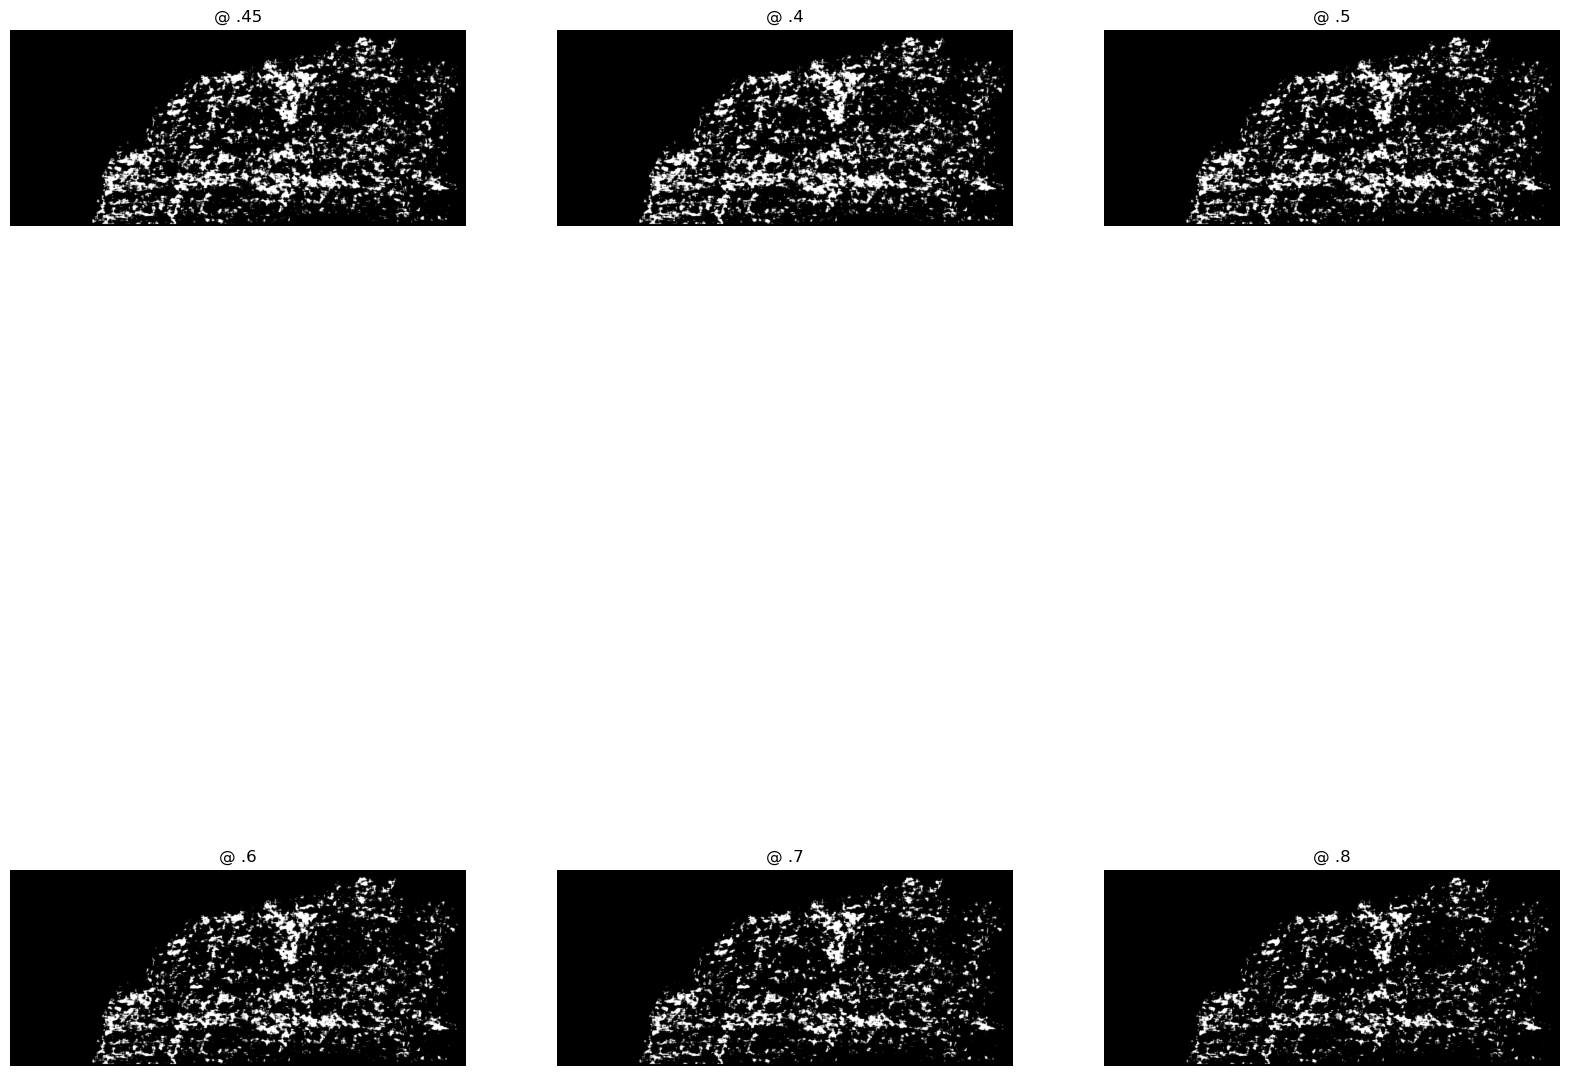

Graph has saved


In [24]:
save_predictions_image(preds2, None)

In [25]:
print("Something")

Something


# Continue with the original notebook

In [ ]:
fragment_ids = os.listdir(TEST_DIR)
submission = []

for fragment_id in fragment_ids:
    if fragment_id == "b":
        continue
    start = time.time()
    print(f"Inference for fragment id: {fragment_id}")
    ink_pred = infer_for_fragment(fragment_id, config, model)

    print("Do RLE for this fragment")
    start_rle = time.time()
    submission.append({"Id": fragment_id, "Predicted": orig_rle(ink_pred)})
    # Can also try orig_rle fast_rle  combined_rle
    end_rle = time.time()
    total = start_rle - end_rle
    print(f"Rle took {total:.4} seconds or {total/60:.3} minutes")
    
    end = time.time()
    total = start - end
    print(f"Inference for fragment {fragment_id} took {total:.4} seconds or {total/60:.3} minutes")

## Plot prediction

In [ ]:
submission_df = pd.DataFrame(submission)
submission_df.to_csv("submission.csv", index=False)
submission_df

In [ ]:
print("Completed")